In [35]:
import numpy as np
import pandas as pd


In [36]:
# Each Arg(Cause/Event) to Topic Proportions Mapping
arr = np.load("ones_argsToTopics_NYT_2019_50.npy")
print(arr.shape) #Topics X Args

(50, 76078)


In [37]:
#Top topic for each arg by proprtion
df_results = pd.DataFrame(arr.argmax(axis=0))

In [38]:
#mapping the actual data to a topic by joining arg0_id (cause) and arg1_id (event)
df = pd.read_csv("ones_Final_NYT_2019.csv")

df["arg0_topicid"] = df.join(df_results,on=["arg0_id"])[0]
df["arg1_topicid"] = df.join(df_results,on=["arg1_id"])[0]
df.to_csv("NYT_all.csv",index=False)

df.head()

,Unnamed: 0,id,index,outlet,political_leaning,date_publish,text,args,year,arg0,arg1,arg0_id,arg1_id,arg0_topicid,arg1_topicid
0,0,4075871,polusa_4075871_1_1,The New York Times,LEFT,2019-01-01 00:00:00,Serious economists warned that this growth was...,('driven by the shift from fiscal austerity to...,2019,driven by the shift from fiscal austerity to w...,that this growth was a temporary lift — a “sug...,50463,61211,20,42
1,1,4075871,polusa_4075871_6_0,The New York Times,LEFT,2019-01-01 00:00:00,"In particular, the uncertainty may be deterrin...","('In', 'business spending.')",2019,In,business spending.,9568,2895,32,49
2,2,4075871,polusa_4075871_6_1,The New York Times,LEFT,2019-01-01 00:00:00,"In particular, the uncertainty may be deterrin...","('the uncertainty may be deterring', 'business...",2019,the uncertainty may be deterring,business spending.,3301,2895,10,49
3,3,4083565,polusa_4083565_5_0,The New York Times,LEFT,2019-01-01 00:00:03,George Wallace spent most of life trying to ho...,('trying to hold back the tide of change that ...,2019,trying to hold back the tide of change that Ro...,George Wallace spent most of life,34186,19687,27,46
4,4,4083565,polusa_4083565_9_0,The New York Times,LEFT,2019-01-01 00:00:03,"To defenders of the old order, America had don...","('To defenders of the old order, America had d...",2019,"To defenders of the old order, America had don...",and there was no need to open the floodgates.,28574,42045,0,4


In [39]:
#Pivoting by Cause topic and Effect Topic and then generating a count
causalmatrix = pd.pivot_table(df, values='index', index='arg0_topicid', columns='arg1_topicid',
               aggfunc='count')
causalmatrix.head()
#Pivoting by Event topic and Cause Topic and then generating a count (i.e a transpose of above)
causalmatrix_t = pd.pivot_table(df, values='index', index='arg1_topicid', columns='arg0_topicid',
               aggfunc='count')
causalmatrix_t.head()

arg0_topicid,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
arg1_topicid,,,,,,,,,,,,,,,,,,,,,
0,135.0,46.0,31.0,33.0,67.0,71.0,59.0,18.0,78.0,56.0,...,34.0,28.0,58.0,66.0,2.0,21.0,42.0,65.0,14.0,29.0
1,40.0,15.0,15.0,11.0,31.0,18.0,21.0,9.0,36.0,17.0,...,9.0,9.0,18.0,26.0,NaN,14.0,14.0,20.0,6.0,12.0
2,43.0,12.0,14.0,11.0,22.0,19.0,24.0,5.0,30.0,14.0,...,16.0,12.0,16.0,30.0,1.0,20.0,16.0,43.0,11.0,12.0
3,27.0,12.0,14.0,6.0,20.0,17.0,18.0,5.0,23.0,15.0,...,10.0,8.0,8.0,26.0,1.0,11.0,11.0,16.0,9.0,11.0
4,82.0,28.0,29.0,24.0,46.0,47.0,36.0,13.0,57.0,37.0,...,23.0,32.0,26.0,49.0,6.0,19.0,26.0,57.0,17.0,15.0


In [40]:
#looking for pairs where : count(TopicA Causing TopicB) > (m=4)*count(TopicB causing Topic A) 
#This is to make sure that they are just not corelated
# m=4 fr NBC
# m=3 for NYT
final_arr = np.array(causalmatrix - 3*causalmatrix_t)
indices = np.where(final_arr > 0)
pairs = [(indices[0][i],indices[1][i]) for i in range(len(indices[0])) if indices[1][i]!=31]
pairs_weights = [(indices[0][i],indices[1][i],final_arr[indices[0][i]][indices[1][i]]) for i in range(len(indices[0])) if indices[1][i]!=31] 


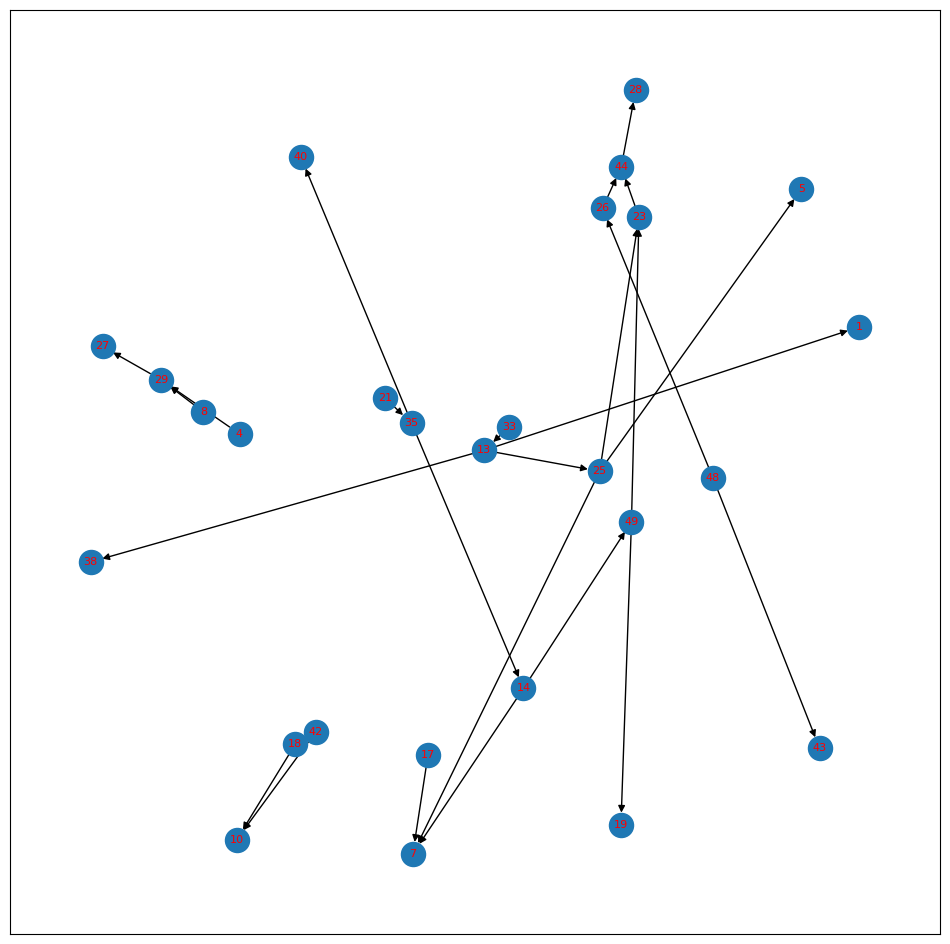

In [41]:
# Plotting the resultant graph using networkx
import networkx as nx
import matplotlib.pyplot as plt
G = nx.DiGraph()
G.add_edges_from(pairs)
plt.figure(figsize=(12,12)) 
nx.draw_networkx(G, font_size=8, font_color='r')

#This Graph is then manually topic labeled and refined for finer results. The final results are available on the report

In [46]:
import pickle
with open('NYT_CG.pickle', 'wb') as handle:
    pickle.dump(pairs, handle)